Setup of libraries, microphones and speakers

In [1]:
#Intialising Libraries
import pyaudio
import wave
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal as sig
import soundcard as sc

In [2]:
# get a list of all speakers:
speakers = sc.all_speakers()
print(speakers)
# get the current default speaker on your system:
default_speaker = sc.default_speaker()
print(default_speaker)
# get a list of all microphones:
mics = sc.all_microphones()
print(mics)
# get the current default microphone on your system:
default_mic = sc.default_microphone()
print(default_mic)

# search for a sound card by substring:
sc.get_speaker('Scarlett')
one_mic = sc.get_microphone('Scarlett')


p = pyaudio.PyAudio()
info = p.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
print(numdevices)

for i in range(0, numdevices):
    print("Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))

[<Speaker Speakers (Realtek(R) Audio) (2 channels)>, <Speaker Speakers (Scarlett 2i2 USB) (2 channels)>]
<Speaker Speakers (Scarlett 2i2 USB) (2 channels)>
[<Microphone Microphone Array (Realtek(R) Audio) (2 channels)>, <Microphone Microphone (Scarlett 2i2 USB) (2 channels)>]
<Microphone Microphone (Scarlett 2i2 USB) (2 channels)>
6
Device id  0  -  Microsoft Sound Mapper - Input
Device id  1  -  Microphone (Scarlett 2i2 USB)
Device id  2  -  Microphone Array (Realtek(R) Au
Device id  3  -  Microsoft Sound Mapper - Output
Device id  4  -  Speakers (Scarlett 2i2 USB)
Device id  5  -  Speakers (Realtek(R) Audio)


FFT (input = array of error data, output = array of frequencies based on importance of magnitude) [OUTDATED]


In [3]:
from scipy.signal import argrelextrema

# Takes the arguments (Data, NumFreqs=0, plot=0)
# Data is a 1D array of y data
# If NumFreqs is specified as N it will return only the N most prominent frequencies
# if plot is set to 1 it will plot out the y data and its FFT

def FreqFinder(Data, NumFreqs=0, plot=0):
    L = len(Data)
    x = np.arange(0,L)
    Windowed = np.zeros(L)       # Sine Window the data to create a periodic function
    for i in range (L):
        Windowed[i] = Data[i] * np.sin(i*np.pi/L)

    yk = abs(np.fft.fft(Windowed))            # FFT the y-Data
        
    if (plot == 1):                          # Plot the windowed and FFted data if requested
        plt.plot(x, Data)
        plt.title("Windowed Input Data")
        plt.show()
        plt.plot(x, yk)  
        plt.title("FFT results")
        plt.show()

    imax = argrelextrema(yk[:int(0.5*L)], np.greater)[0]
    Extremas = np.ones((len(imax), 2))
    for i in range (len(imax)):
        Extremas[i][0] = imax[i]
        Extremas[i][1] = yk[imax[i]]
    imax = sorted(Extremas, key=lambda t: t[1])
    if ((NumFreqs!=0)&(NumFreqs<len(imax))):
        imax = imax[:NumFreqs]
    for i in range (len(imax)):
        imax[i] = imax[i][0]
 
    Freqs = np.zeros(len(imax))
    for i in range(len(imax)):
        Freqs[i] = imax[i]*2*np.pi*44100/(L*2048)
    return Freqs

Weight Adjustment

#STAGE 3: Transform Error Noise into Anti-Noise

#STAGE 4: decompose into single frequencies using FFT (only occurs onces)

#STAGE 5: generate A's and B's for each unique frequency (start with N = X)

#STAGE 6: apply single tone filter

#STAGE 7: adjust weights until noise is completely reduced (start with sleep(10))

#STAGE 8: iterate through frequencies, convoluting sounds as you go e.g., A1 B1 > A1+A2 B1+B2 > ...

[50.63565858 58.6564949 ]


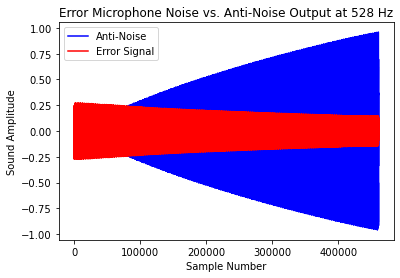

In [4]:
#STAGE 1: standard block code

#ANC parameters
CHUNK = 2048
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 44100

#now that we have the secondary path implement the ANC
p = pyaudio.PyAudio()

NumFreqs = 2 #Number of frequencies to analyse
x=np.arange(0,CHUNK,1) #for calculating the reference each iteration

#secondary path arrays
response_frames = np.array([])
control_frames = np.array([])
control_frames = np.append(control_frames, np.zeros(CHUNK))
count = 0

#ANC parameters
frames = np.array([])
output = np.zeros(CHUNK)
outputs = np.array([])
response = np.zeros(CHUNK)
responses = np.array([])

#learning rate of ANN
LR = 0.00002

#high pass filter
normal_cutoff = 50/(0.5 * RATE)
b, a = sig.butter(6, normal_cutoff, btype='high', analog=False)

#get the transfer function of the secondary path S
S = np.loadtxt('Filter.txt')

#create weights array <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<CURRENTLY SET TO TWO FREQ
W = np.zeros((4,1))

#STAGE 2: read error noise
def main():
    
    #open the audio stream
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    output=True,
                    input=True,
                    input_device_index = 1, 
                    output_device_index = 4, 
                    frames_per_buffer=CHUNK,
                    stream_callback=callback)
    
    #callback function is called while this loop waits
    stream.start_stream()
    while stream.is_active():
        time.sleep(20)
        stream.stop_stream()
    stream.close()

    #plot the error over time
    numpydata = np.hstack(frames)
    
    #plot the outputs over time
    numpydata1 = np.hstack(outputs)
    plt.plot(numpydata1, 'b-', label = 'Anti-Noise')
    plt.plot(numpydata, 'r-', label = 'Error Signal')
    plt.title('Error Microphone Noise vs. Anti-Noise Output at 528 Hz')
    plt.xlabel('Sample Number')
    plt.ylabel('Sound Amplitude')
    plt.legend()
    plt.show()

    p.terminate()


#called everytime there is new audio to record or play
def callback(in_data, frame_count, time_info, flag):
    global response_frames, control_frames, output_sin, frames, outputs, responses, x, count, S, Freqs
    
    input_audio = in_data
      
    #measure the transfer function for the first 200 frames
    if (count < 100):
        #record the audio through the microphone
        response_frames = np.append(response_frames, np.frombuffer(input_audio, dtype=np.float32))
    
        #play combination of 392Hz and 528Hz
        output_sin = 0.25*(np.sin(2*np.pi*392*(1/RATE)*x)+np.sin(2*np.pi*528*(1/RATE)*x))
        x = x+CHUNK

        output_audio = output_sin
        control_frames = np.append(control_frames, output_audio)

        count = count + 1
        y_out = output_audio
     
    #calculate the transfer function in this frame
    elif (count == 100):
        
        #don't care about inputs and outputs
        input_audio = in_data
        y_out = np.zeros(CHUNK)
        
        #fourier transforms of input and output
        nfft = 16384 #frequency range for fft

        #cross spectral density between the control output and microphone input is the Fourier Transform of their convolution
        [f,sXY] = sig.csd(control_frames, response_frames, fs=RATE, window='hanning', nperseg=nfft, noverlap=nfft/2, nfft=nfft)
        [f,sXX] = sig.welch(control_frames, fs=RATE, window='hanning', nperseg=nfft, noverlap=nfft/2, nfft=nfft)

        #the transfer function is H = Sxy/Sxx
        H = sXY/sXX
        
        #INDEX AS ARRAY <<<<<<<<<< 
        Freqs = FreqFinder(response_frames[-5*CHUNK:-1], NumFreqs = NumFreqs)
        Freqs = np.sort(Freqs)
        S = np.zeros((len(Freqs), 2))
        for i in range(len(Freqs)):
            index = (np.abs(f-Freqs[i])).argmin() #select the indices of the transfer function closest to the frequency of the noise
            S[i][0] = np.real(H[index])
            S[i][1] = np.imag(H[index])
        
        np.savetxt('Filter.txt', S)
        np.savetxt('Freqs.txt', S)
        print(Freqs)
            
        count = count + 1
     
    #delay to start the disturbance signal
    elif (count > 100 and count < 200):
        
        #don't care about inputs and outputs
        y_out = np.zeros(CHUNK)
        count = count + 1
    
    #do the noise cancelling FREQ 1 and FREQ 2
    else:
        
        #record the error through the microphone
        error = input_audio
        frames = np.append(frames, np.frombuffer(error, np.float32))
        errorData = sig.lfilter(b, a, np.frombuffer(error, dtype=np.float32))

        #new reference signals
        x_reference_sin0 = np.sin(2*np.pi*392*(1/RATE)*x)
        x_reference_cos0 = np.cos(2*np.pi*392*(1/RATE)*x)
        
        x_reference_sin1 = np.sin(2*np.pi*528*(1/RATE)*x)
        x_reference_cos1 = np.cos(2*np.pi*528*(1/RATE)*x)
        x = x+CHUNK

        #frequency response - recall that multiplying by i is the same as a 90 degree phase shift to the right (isin -> cos, icos -> -sin)
        filtered_sin0 = S[0][0]*x_reference_sin0 + S[0][1]*x_reference_cos0  # y = (H_R + iH_I)(sin(wt)) = H_r sin(wt) + iH_I sin(wt)
        filtered_cos0 = S[0][0]*x_reference_cos0 - S[0][1]*x_reference_sin0  # y = (H_R + iH_I)(cos(wt)) = H_r cos(wt) + iH_I cos(wt)
        filtered_sin1 = S[1][0]*x_reference_sin1 + S[1][1]*x_reference_cos1  # y = (H_R + iH_I)(sin(wt)) = H_r sin(wt) + iH_I sin(wt)
        filtered_cos1 = S[1][0]*x_reference_cos1 - S[1][1]*x_reference_sin1  # y = (H_R + iH_I)(cos(wt)) = H_r cos(wt) + iH_I cos(wt)
        
        #update the weights
        W[0] = W[0] - (LR)*np.sum(errorData*filtered_sin0)
        W[1] = W[1] - (LR)*np.sum(errorData*filtered_cos0)
        W[2] = W[2] - (LR)*np.sum(errorData*filtered_sin1)
        W[3] = W[3] - (LR)*np.sum(errorData*filtered_cos1)

        #references of next frame
        x_sin_next0 = np.sin(2*np.pi*392*(1/RATE)*x)
        x_cos_next0 = np.cos(2*np.pi*392*(1/RATE)*x)
        
        x_sin_next1 = np.sin(2*np.pi*528*(1/RATE)*x)
        x_cos_next1 = np.cos(2*np.pi*528*(1/RATE)*x)

        #output calculated with the weights and the next reference frame
        output = W[0]*x_sin_next0 + W[1]*x_cos_next0 + W[2]*x_sin_next1 + W[3]*x_cos_next1

        outputs = np.append(outputs, output.astype(np.float32))
        y_out = output
        
    return (y_out.astype(np.float32).tobytes(), pyaudio.paContinue)

main()

Graphing Error against time

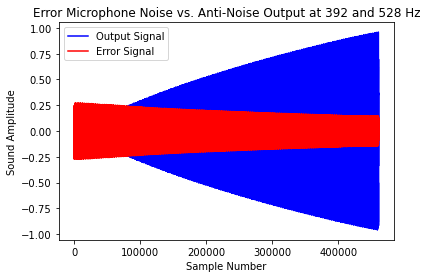

In [5]:
from scipy.io import wavfile

#plot the error over time
numpydata = np.hstack(frames)

#plot the outputs over time
numpydata1 = np.hstack(outputs)

plt.plot(numpydata1, 'b-', label = 'Output Signal')
plt.plot(numpydata, 'r-', label = 'Error Signal')
plt.title('Error Microphone Noise vs. Anti-Noise Output at 392 and 528 Hz')
plt.xlabel('Sample Number')
plt.ylabel('Sound Amplitude')
plt.legend()
plt.show()

wavfile.write('Error Signal.wav', 44100, numpydata.astype(np.float32()))